In [ ]:
import cv2 as cv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
class_label_encoding = {
    'SPOILED': 0,
    'HALF': 1,
    'FRESH': 2
}

# Loading Images

In [ ]:
def load_images(file_path, output_x, output_y):
    for file_name in os.listdir(file_path):
        class_name = file_name.split('-')[0]
        if (class_name == '_classes.csv'): continue
        img = cv.imread(file_path + file_name).astype('float32')
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (128, 128), interpolation = cv.INTER_AREA)
        img /= 255
        output_x.append(img)
        output_y.append(class_label_encoding[class_name])

In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []

load_images('data/train/', train_x, train_y)
load_images('data/valid/', test_x, test_y)

In [ ]:
train_x[0].shape

# Feature Extraction

## Color Histogram
Jason

In [ ]:
def extract_color_histogram(image, bins=32):
    """
    Extract color histogram features from an image.
    
    Parameters:
    - image: The input image (should be in RGB format)
    - bins: Number of bins for the histogram
    
    Returns:
    - histogram_features: Flattened histogram features
    """
    # Extract histograms for each channel
    hist_r = cv.calcHist([image], [0], None, [bins], [0, 1])  # Changed range to [0, 1] since you're normalizing images
    hist_g = cv.calcHist([image], [1], None, [bins], [0, 1])
    hist_b = cv.calcHist([image], [2], None, [bins], [0, 1])
    
    # Normalize the histograms
    cv.normalize(hist_r, hist_r, 0, 1, cv.NORM_MINMAX)
    cv.normalize(hist_g, hist_g, 0, 1, cv.NORM_MINMAX)
    cv.normalize(hist_b, hist_b, 0, 1, cv.NORM_MINMAX)
    
    # Flatten and concatenate the histograms
    histogram_features = np.concatenate([
        hist_r.flatten(), 
        hist_g.flatten(), 
        hist_b.flatten()
    ])
    
    return histogram_features

In [ ]:
def plot_color_histogram(image, bins=32, title="Color Histogram"):
    """
    Plot the color histogram of an image.
    
    Parameters:
    - image: The input image (should be in RGB format)
    - bins: Number of bins for the histogram
    - title: Title for the plot
    
    Returns:
    - None (displays the plot)
    """
    # Create a figure with subplots
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    
    # Display the original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Get histogram features using your existing function
    features = extract_color_histogram(image, bins)
    
    # Split the features back into channels
    channel_length = len(features) // 3
    hist_r = features[:channel_length].reshape(bins, 1)
    hist_g = features[channel_length:2*channel_length].reshape(bins, 1)
    hist_b = features[2*channel_length:].reshape(bins, 1)
    
    # Define colors and channels
    colors = ['r', 'g', 'b']
    channels = ['Red', 'Green', 'Blue']
    hists = [hist_r, hist_g, hist_b]
    
    # Plot histograms for each channel
    for i, (hist, col, chan) in enumerate(zip(hists, colors, channels)):
        ax[i+1].plot(hist, color=col)
        ax[i+1].set_xlim([0, bins])
        ax[i+1].set_title(f'{chan} Histogram')
        ax[i+1].set_xlabel('Bins')
        ax[i+1].set_ylabel('# of Pixels')
        ax[i+1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return features

In [ ]:
image = train_x[0]  # Get the first image
image_1_filter_1 = plot_color_histogram(image, bins=100, title="Meat Sample Color Histogram")


In [ ]:
image_1_filter_1.shape

In [ ]:
# Extract features from training and testing sets
train_features = []
for img in train_x:
    hist_features = extract_color_histogram(img)
    train_features.append(hist_features)
train_features = np.array(train_features)


test_features = []
for img in test_x:
    hist_features = extract_color_histogram(img)
    test_features.append(hist_features)
test_features = np.array(test_features)

print(train_features)

## Local Binary Pattern
Aiden

In [ ]:
def get_pixel(img, center, x, y): 
      
    new_value = 0
      
    try: 
        # if local neighbourhood pixel value is greater than or equal to center pixel values then set it to 1 
        if img[x][y] >= center: 
            new_value = 1
              
    except: 
        # exception required when neighbourhood value of center pixel value is null
        pass
      
    return new_value 
   
# Function for calculating LBP 
def lbp_calculated_pixel(img, x, y): 
   
    center = img[x][y] 
   
    val_ar = [] 
      
    # top_left 
    val_ar.append(get_pixel(img, center, x-1, y-1)) 
      
    # top 
    val_ar.append(get_pixel(img, center, x-1, y)) 
      
    # top_right 
    val_ar.append(get_pixel(img, center, x-1, y + 1)) 
      
    # right 
    val_ar.append(get_pixel(img, center, x, y + 1)) 
      
    # bottom_right 
    val_ar.append(get_pixel(img, center, x + 1, y + 1)) 
      
    # bottom 
    val_ar.append(get_pixel(img, center, x + 1, y)) 
      
    # bottom_left 
    val_ar.append(get_pixel(img, center, x + 1, y-1)) 
      
    # left 
    val_ar.append(get_pixel(img, center, x, y-1)) 
       
    # convert binary values to decimal 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128] 
   
    val = 0
      
    for i in range(len(val_ar)): 
        val += val_ar[i] * power_val[i] 
          
    return val


def lbp_output(img_bgr):
    height, width, _ = img_bgr.shape 
   
    # convert RGB to gray 
    img_gray = cv.cvtColor(img_bgr, 
                            cv.COLOR_BGR2GRAY) 
       
    # create numpy array as same height and width of RGB image 
    img_lbp = np.zeros((height, width), 
                       np.float32) 
       
    for i in range(0, height): 
        for j in range(0, width): 
            img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)

    return img_lbp

In [ ]:
img_bgr = train_x[0]
img_lbp = lbp_output(img_bgr)
  
plt.imshow(img_bgr) 
plt.show()
   
plt.imshow(img_lbp, cmap ="gray")
plt.show()

In [ ]:
def save_images_lbp(imgs, labels, train_test='train'):
    label_text = ['SPOILED', 'HALF', 'FRESH']
    for image in range(len(imgs)):
        lbp_image = lbp_output(imgs[image])
        filename = f'data/lbp/{train_test}/{label_text[labels[image]]}-{image}-lbp.jpg'
        cv.imwrite(filename, lbp_image)

In [ ]:
# save_images_lbp(train_x, train_y, train_test='train')

In [ ]:
# save_images_lbp(test_x, test_y, train_test='test')

## Histograms of Oriented Gradients
Fiona

In [ ]:
# Adapted from here: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
def make_hog(image, visualize=False):
    features, hog_image = hog(
            image,
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            visualize=True,
            channel_axis=-1
        )

    if visualize:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()
    return features

In [ ]:
make_hog(train_x[1], True)

In [ ]:
train_features_hog = []
test_features_hog = []

for image in train_x:
    train_features_hog.append(make_hog(image))

for image in test_x:
    test_features_hog.append(make_hog(image))

# Classification

## Decision Tree
Jason

In [ ]:
def train_decision_tree(x_train_tree, y_train_tree, x_test_tree, y_test_tree, filter, max_depth=5, show_tree=True, feature_names=None):
    """
    Train a decision tree classifier on any type of features, with optional histogram visualization.
    
    Parameters:
    - x_train_tree: Training features
    - y_train_tree: Training labels
    - x_test_tree: Test features
    - y_test_tree: Test labels
    - max_depth: Maximum depth of the decision tree
    - show_tree: Whether to visualize the decision tree
    - feature_names: Names of features (will be auto-generated if None)
    
    Returns:
    - dt_classifier: Trained decision tree classifier
    - accuracy: Classification accuracy on test set
    - report: Classification report
    """

    # Create a list of class names
    class_names=['SPOILED', 'HALF', 'FRESH']
    
    # Create and train a Decision Tree classifier
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt_classifier.fit(x_train_tree, y_train_tree)
    
    # Make predictions
    predictions = dt_classifier.predict(x_test_tree)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test_tree, predictions)
    report = classification_report(y_test_tree, predictions, target_names=class_names)
    conf_matrix = confusion_matrix(y_test_tree, predictions)
    
    # Print results
    print(f"Decision Tree Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations in the confusion matrix
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Show decision tree if requested
    if show_tree:
        # Create feature names if not provided
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(x_train_tree.shape[1])]
            
        plt.figure(figsize=(15, 10))
        plot_tree(dt_classifier, 
                  feature_names=feature_names,
                  class_names=class_names,
                  filled=True, 
                  rounded=True, 
                  fontsize=8)
        plt.title(f"Decision Tree for {filter}")
        plt.tight_layout()
        plt.show()
    
    return dt_classifier, accuracy, report

## Random Forest
Aiden

In [ ]:
def train_random_forest(x_train_forest, y_train_forest, x_test_forest, y_test_forest, n_estimators=100, criterion='gini', max_depth=None,
                        min_samples_split=2, min_samples_leaf=1, max_features='sqrt'):
    # Create Random Forest classifer object
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
    
    # Train Random Forest Classifer
    clf.fit(x_train_forest,y_train_forest)
    
    #Predict the response for test dataset
    y_pred = clf.predict(x_test_forest)
    
    accuracy = accuracy_score(y_test_forest, y_pred)
    precision = precision_score(y_test_forest, y_pred)
    recall = recall_score(y_test_forest, y_pred)
    f1 = f1_score(y_test_forest, y_pred)
    confusion = confusion_matrix(y_test_forest, y_pred)

    return accuracy, precision, recall, f1

# Knn
Fiona

In [ ]:
def train_knn(x_train, y_train, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)

    return knn

In [ ]:
def knn_report(knn, x_test, y_test):
    predictions = knn.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, target_names=['SPOILED', 'HALF', 'FRESH'])
    print(f"Knn Accuracy: {accuracy:.4f}")
    print(report)

In [ ]:
# Adapted from here: https://medium.com/@agrawalsam1997/hyperparameter-tuning-of-knn-classifier-a32f31af25c7
def tune_knn(x_train, y_train, x_test, y_test, title,
             n_start=1, n_stop=10, n_step=1):
    train_scores = {}
    test_scores = {}
    f1_scores = {}
    models = {}

    n_neighbors = np.arange(n_start, n_stop, n_step)
    for n in n_neighbors:
        knn = train_knn(x_train, y_train, n_neighbors=n)
        train_scores[n] = knn.score(x_train, y_train)
        test_scores[n] = knn.score(x_test, y_test)
        f1_scores[n] = f1_score(y_test, knn.predict(x_test), average='macro')
        models[n] = knn

    plt.plot(n_neighbors, train_scores.values(), label="Train Accuracy")
    plt.plot(n_neighbors, test_scores.values(), label="Test Accuracy")
    plt.plot(n_neighbors, f1_scores.values(), label="F1 Score", linestyle='--')
    plt.xlabel("Number of Neighbors")
    plt.ylabel("Accuracy")
    plt.title(f"KNN ({title}): Varying Number of Neighbors")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
print("HOG")
knn = train_knn(train_features_hog, train_y)
knn_report(knn, test_features_hog, test_y)

In [ ]:
#tune_knn(train_features, train_y, test_features, test_y, "Color Histograms", n_stop=50)
#tune_knn(train_features_hog, train_y, test_features_hog, test_y, "HOG", n_stop=50)

# Neural Network

In [ ]:
class FeedforwardNN(tf.keras.Model):
    """
    A configurable feedforward neural network implemented with TensorFlow
    """
    def __init__(self, input_dim, hidden_layers=[64, 32], output_classes=3, 
                 dropout_rate=0.2, activation='relu', batch_norm=True):
        """
        Initialize the neural network.
        
        Parameters:
        -----------
        input_dim : int
            Number of input features
        hidden_layers : list of int
            List containing the number of neurons in each hidden layer
        output_classes : int
            Number of output classes (3 for SPOILED, HALF, FRESH)
        dropout_rate : float
            Dropout rate for regularization
        activation : str
            Activation function ('relu', 'sigmoid', 'tanh')
        batch_norm : bool
            Whether to use batch normalization
        """
        super(FeedforwardNN, self).__init__()
        
        # Store activation function name
        self.activation_name = activation
        
        # Build network architecture
        self.model_layers = []
        
        # Add hidden layers
        for units in hidden_layers:
            # Add linear layer
            self.model_layers.append(layers.Dense(units))
            
            # Add batch normalization if enabled
            if batch_norm:
                self.model_layers.append(layers.BatchNormalization())
            
            # Add activation function
            self.model_layers.append(layers.Activation(activation))
            
            # Add dropout if enabled
            if dropout_rate > 0:
                self.model_layers.append(layers.Dropout(dropout_rate))
        
        # Add output layer
        self.model_layers.append(layers.Dense(output_classes))
    
    def call(self, x, training=False):
        """Forward pass through the network."""
        for layer in self.model_layers:
            # For batch normalization and dropout layers, we need to specify training mode
            if isinstance(layer, (layers.BatchNormalization, layers.Dropout)):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x


class MeatClassifier:
    """
    A wrapper class for training and evaluating the TensorFlow neural network model.
    """
    def __init__(self, input_dim, hidden_layers=[64, 32], output_classes=3, 
                 dropout_rate=0.2, activation='relu', batch_norm=True,
                 learning_rate=0.001, weight_decay=0.001, device=None):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        input_dim : int
            Number of input features
        hidden_layers : list of int
            List containing the number of neurons in each hidden layer
        output_classes : int
            Number of output classes (3 for SPOILED, HALF, FRESH)
        dropout_rate : float
            Dropout rate for regularization
        activation : str
            Activation function ('relu', 'sigmoid', 'tanh')
        batch_norm : bool
            Whether to use batch normalization
        learning_rate : float
            Learning rate for optimizer
        weight_decay : float
            Weight decay (L2 regularization) strength
        device : str or None
            Device to use ('GPU' or 'CPU'). If None, will use GPU if available.
        """
        # Set device
        if device is None:
            # Let TensorFlow handle device placement
            self.device_name = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
        else:
            self.device_name = f"/{device.upper()}:0"
        
        # Create strategy for device placement
        self.strategy = tf.distribute.OneDeviceStrategy(device=self.device_name)
        
        with self.strategy.scope():
            # Initialize model
            self.model = self._build_model(
                input_dim=input_dim,
                hidden_layers=hidden_layers,
                output_classes=output_classes,
                dropout_rate=dropout_rate,
                activation=activation,
                batch_norm=batch_norm
            )
            
            # Initialize optimizer with weight decay (L2 regularization)
            self.optimizer = optimizers.Adam(
                learning_rate=learning_rate, 
                weight_decay=weight_decay
            )
            
            # Compile the model
            self.model.compile(
                optimizer=self.optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
            )
        
        # For tracking training progress
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        # For storing the best model
        self.best_val_loss = float('inf')
        self.best_model_weights = None
        
        # For feature scaling
        self.scaler = StandardScaler()
    
    def _build_model(self, input_dim, hidden_layers, output_classes, 
                   dropout_rate, activation, batch_norm):
        """Build and return a Keras Sequential model."""
        model = models.Sequential()
        
        # Input layer
        model.add(layers.Input(shape=(input_dim,)))
        
        # Add hidden layers
        for units in hidden_layers:
            # Add dense layer
            model.add(layers.Dense(units))
            
            # Add batch normalization if enabled
            if batch_norm:
                model.add(layers.BatchNormalization())
            
            # Add activation function
            model.add(layers.Activation(activation))
            
            # Add dropout if enabled
            if dropout_rate > 0:
                model.add(layers.Dropout(dropout_rate))
        
        # Add output layer
        model.add(layers.Dense(output_classes))
        
        return model
    
    def train(self, features, labels, test_size=0.2, batch_size=32, epochs=100, 
              early_stopping_patience=20, random_state=42, verbose=True):
        """
        Train the neural network.
        
        Parameters:
        -----------
        features : numpy array
            Feature matrix
        labels : numpy array
            Labels
        test_size : float
            Proportion of data to use for validation
        batch_size : int
            Batch size for training
        epochs : int
            Number of training epochs
        early_stopping_patience : int
            Number of epochs with no improvement after which training will stop
        random_state : int
            Random seed for reproducibility
        verbose : bool
            Whether to print training progress
            
        Returns:
        --------
        self : MeatClassifier
            The trained classifier
        """
        # Convert to numpy arrays if not already
        features = np.array(features)
        labels = np.array(labels)
        
        # Split data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            features, labels, test_size=test_size, 
            random_state=random_state, stratify=labels
        )
        
        # Scale features
        X_train = self.scaler.fit_transform(X_train)
        X_val = self.scaler.transform(X_val)
        
        # Define callbacks
        callbacks = []
        
        # Early stopping callback
        if early_stopping_patience > 0:
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=early_stopping_patience,
                restore_best_weights=True,
                verbose=1 if verbose else 0
            )
            callbacks.append(early_stopping)
        
        # Custom callback to store training history
        class TrainingHistoryCallback(tf.keras.callbacks.Callback):
            def __init__(self, classifier):
                super(TrainingHistoryCallback, self).__init__()
                self.classifier = classifier
                
            def on_epoch_end(self, epoch, logs=None):
                self.classifier.train_losses.append(logs.get('loss'))
                self.classifier.val_losses.append(logs.get('val_loss'))
                self.classifier.train_accuracies.append(logs.get('accuracy'))
                self.classifier.val_accuracies.append(logs.get('val_accuracy'))
                
                # Save best model weights
                if logs.get('val_loss') < self.classifier.best_val_loss:
                    self.classifier.best_val_loss = logs.get('val_loss')
                    self.classifier.best_model_weights = self.model.get_weights()
        
        # Add custom callback
        history_callback = TrainingHistoryCallback(self)
        callbacks.append(history_callback)
        
        # Train the model
        with self.strategy.scope():
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1 if verbose else 0
            )
        
        # Restore best model weights if available
        if self.best_model_weights is not None:
            self.model.set_weights(self.best_model_weights)
        
        return self
    
    def predict(self, features):
        """
        Make predictions on new data.
        
        Parameters:
        -----------
        features : numpy array
            Feature matrix
            
        Returns:
        --------
        numpy array
            Predicted class indices
        """
        # Scale features
        features_scaled = self.scaler.transform(features)
        
        # Make predictions (logits)
        logits = self.model.predict(features_scaled)
        
        # Get class predictions
        predictions = np.argmax(logits, axis=1)
        
        return predictions
    
    def predict_proba(self, features):
        """
        Predict class probabilities.
        
        Parameters:
        -----------
        features : numpy array
            Feature matrix
            
        Returns:
        --------
        numpy array
            Class probabilities
        """
        # Scale features
        features_scaled = self.scaler.transform(features)
        
        # Get logits
        logits = self.model.predict(features_scaled)
        
        # Convert to probabilities using softmax
        probabilities = tf.nn.softmax(logits).numpy()
        
        return probabilities
    
    def evaluate(self, features, labels):
        """
        Evaluate the model on test data.
        
        Parameters:
        -----------
        features : numpy array
            Feature matrix
        labels : numpy array
            True labels
            
        Returns:
        --------
        dict
            Dictionary containing evaluation metrics
        """
        # Get predictions
        y_pred = self.predict(features)
        
        # Calculate accuracy
        accuracy = accuracy_score(labels, y_pred)
        
        # Generate classification report
        class_names = ['SPOILED', 'HALF', 'FRESH']
        report = classification_report(labels, y_pred, target_names=class_names, output_dict=True)
        
        return {
            'accuracy': accuracy,
            'report': report
        }
    
    def plot_training_history(self):
        """Plot the training history (loss and accuracy curves)."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Loss plot
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Curves')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy Curves')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath):
        """Save the model to a file."""
        # Save Keras model
        self.model.save(filepath)
        
        # Save scaler and other metadata
        np.savez(
            filepath + '_metadata.npz',
            best_val_loss=self.best_val_loss,
            scaler_mean=self.scaler.mean_,
            scaler_scale=self.scaler.scale_,
            scaler_var=self.scaler.var_
        )
    
    def load_model(self, filepath):
        """Load the model from a file."""
        # Load Keras model
        self.model = tf.keras.models.load_model(filepath)
        
        # Load metadata
        metadata = np.load(filepath + '_metadata.npz', allow_pickle=True)
        self.best_val_loss = float(metadata['best_val_loss'])
        
        # Recreate scaler
        self.scaler = StandardScaler()
        self.scaler.mean_ = metadata['scaler_mean']
        self.scaler.scale_ = metadata['scaler_scale']
        self.scaler.var_ = metadata['scaler_var']
        
        return self


def train_meat_classifier_tensorflow(features, labels, hidden_layers=[128, 64], 
                                   learning_rate=0.001, weight_decay=0.001,
                                   batch_size=32, epochs=100, test_size=0.2,
                                   early_stopping_patience=20, dropout_rate=0.2,
                                   activation='relu', batch_norm=True,
                                   random_state=42, verbose=True):
    """
    Train and evaluate a neural network for meat classification using TensorFlow.
    
    Parameters:
    -----------
    features : numpy array
        Feature matrix (color histogram, HOG, or LBP features)
    labels : numpy array
        Labels (0: SPOILED, 1: HALF, 2: FRESH)
    hidden_layers : list of int
        List of hidden layer sizes
    learning_rate : float
        Learning rate for optimizer
    weight_decay : float
        Weight decay (L2 regularization) strength
    batch_size : int
        Batch size for training
    epochs : int
        Maximum number of epochs for training
    test_size : float
        Proportion of data to use for testing
    early_stopping_patience : int
        Number of epochs with no improvement after which training will stop
    dropout_rate : float
        Dropout rate for regularization
    activation : str
        Activation function ('relu', 'sigmoid', 'tanh')
    batch_norm : bool
        Whether to use batch normalization
    random_state : int
        Random seed for reproducibility
    verbose : bool
        Whether to print training progress
        
    Returns:
    --------
    dict
        Dictionary containing the classifier, evaluation metrics, and other info
    """
    # Set random seeds for reproducibility
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    
    # Create classifier
    classifier = MeatClassifier(
        input_dim=features.shape[1],
        hidden_layers=hidden_layers,
        output_classes=len(np.unique(labels)),
        dropout_rate=dropout_rate,
        activation=activation,
        batch_norm=batch_norm,
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )
    
    # Train the classifier
    classifier.train(
        features=features,
        labels=labels,
        test_size=test_size,
        batch_size=batch_size,
        epochs=epochs,
        early_stopping_patience=early_stopping_patience,
        random_state=random_state,
        verbose=verbose
    )
    
    # Split data for evaluation (using the same random state for consistency)
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, 
        random_state=random_state, stratify=labels
    )
    
    # Evaluate on test set
    evaluation = classifier.evaluate(X_test, y_test)
    
    # Plot training history
    classifier.plot_training_history()
    
    # Return results
    return {
        'classifier': classifier,
        'accuracy': evaluation['accuracy'],
        'report': evaluation['report']
    }


# Example usage:
"""
# For color histogram features
color_hist_results = train_meat_classifier_tensorflow(
    features=np.array(train_features),  # Assuming this is your color histogram features
    labels=np.array(train_y),
    hidden_layers=[128, 64, 32],
    epochs=150,
    batch_size=16
)

# Print accuracy and classification report
print(f"Test accuracy: {color_hist_results['accuracy']:.4f}")
print("\nClassification Report:")
for class_name, metrics in color_hist_results['report'].items():
    if isinstance(metrics, dict):  # Skip aggregated metrics
        print(f"{class_name}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")

# For HOG features
hog_results = train_meat_classifier_tensorflow(
    features=np.array(train_features_hog),  # Assuming this is your HOG features
    labels=np.array(train_y),
    hidden_layers=[64, 32],
    epochs=150,
    weight_decay=0.01
)
"""

In [ ]:
color_hist_results = train_meat_classifier_tensorflow(
    features=np.array(train_features),  # Assuming this is your color histogram features
    labels=np.array(train_y),
    hidden_layers=[128, 64, 32],
    epochs=150,
    batch_size=16
)

# PCA Function

In [ ]:
def do_pca(xColumns, components=2):
    pca = PCA(n_components = components)
    data_pca = pca.fit_transform(xColumns)
    return data_pca

# Create Dataframes

In [ ]:
def transform_images_to_dataframe(images, filter_type, pca_components=2, labels=None):
    """
    Transform a set of images into a pandas DataFrame with PCA of extracted features.
    
    Parameters:
    - images: List of images (numpy arrays)
    - filter_type: Type of feature extraction ('HIS', 'LBP', or 'HOG')
    - pca_components: Number of PCA components to keep (default=2)
    - labels: Optional list of labels for the images
    
    Returns:
    - DataFrame with PCA components and labels (if provided)
    """
    # Extract features from all images
    all_features = []
    
    for i, img in enumerate(images):
        if filter_type.upper() == "HIS":
            # Extract color histogram features
            features = extract_color_histogram(img)
        
        elif filter_type.upper() == "LBP":
            # Extract LBP features
            lbp_img = lbp_output(img)
            features = lbp_img.flatten()
        
        elif filter_type.upper() == "HOG":
            # Extract HOG features
            features = make_hog(img)
        
        all_features.append(features)
    
    # Convert to numpy array for PCA
    feature_array = np.array(all_features)
    
    # Apply PCA
    pca_result = do_pca(feature_array, components=pca_components)
    
    # Create DataFrame with PCA results
    columns = [f'pca_{i+1}' for i in range(pca_components)]
    df = pd.DataFrame(pca_result, columns=columns)
    
    # Add label if provided
    if labels is not None:
        df['label'] = labels
    
    return df

In [ ]:
# Transform training data into a DataFrame
train_df_hist = transform_images_to_dataframe(train_x, "HIS")

# Transform testing data into a DataFrame
test_df_hist = transform_images_to_dataframe(test_x, "HIS")

# Transform training data into a DataFrame
train_df_lbp = transform_images_to_dataframe(train_x, "lbp")

# Transform testing data into a DataFrame
test_df_lbp = transform_images_to_dataframe(test_x, "lbp")

# Transform training data into a DataFrame
train_df_hog = transform_images_to_dataframe(train_x, "hog")

# Transform testing data into a DataFrame
test_df_hog = transform_images_to_dataframe(test_x, "hog")

In [ ]:
train_df_hist.head(2)

In [ ]:
train_df_lbp.head(2)

In [ ]:
train_df_hog.head(2)


--- Decision Tree Classification for Histogram features ---
Decision Tree Accuracy: 0.6430

Classification Report:
              precision    recall  f1-score   support

     SPOILED       0.70      0.86      0.77       114
        HALF       0.53      0.60      0.57       159
       FRESH       0.73      0.54      0.62       178

    accuracy                           0.64       451
   macro avg       0.66      0.67      0.65       451
weighted avg       0.65      0.64      0.64       451



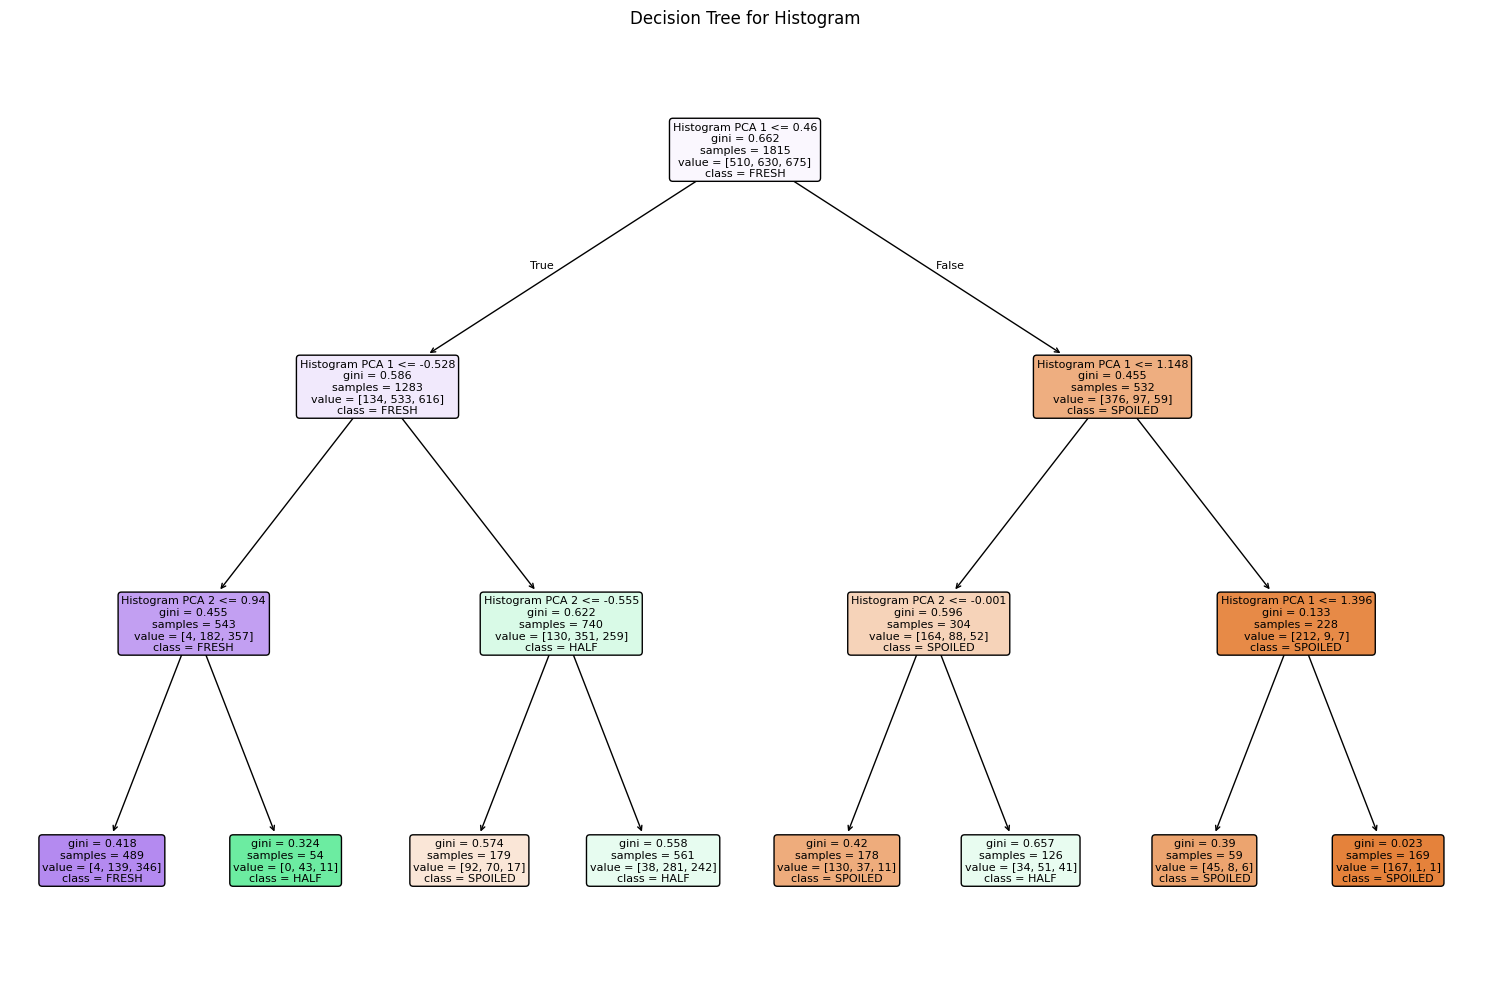


--- Decision Tree Classification for LBP features ---
Decision Tree Accuracy: 0.5055

Classification Report:
              precision    recall  f1-score   support

     SPOILED       0.41      0.76      0.54       114
        HALF       0.59      0.33      0.43       159
       FRESH       0.59      0.49      0.54       178

    accuracy                           0.51       451
   macro avg       0.53      0.53      0.50       451
weighted avg       0.54      0.51      0.50       451



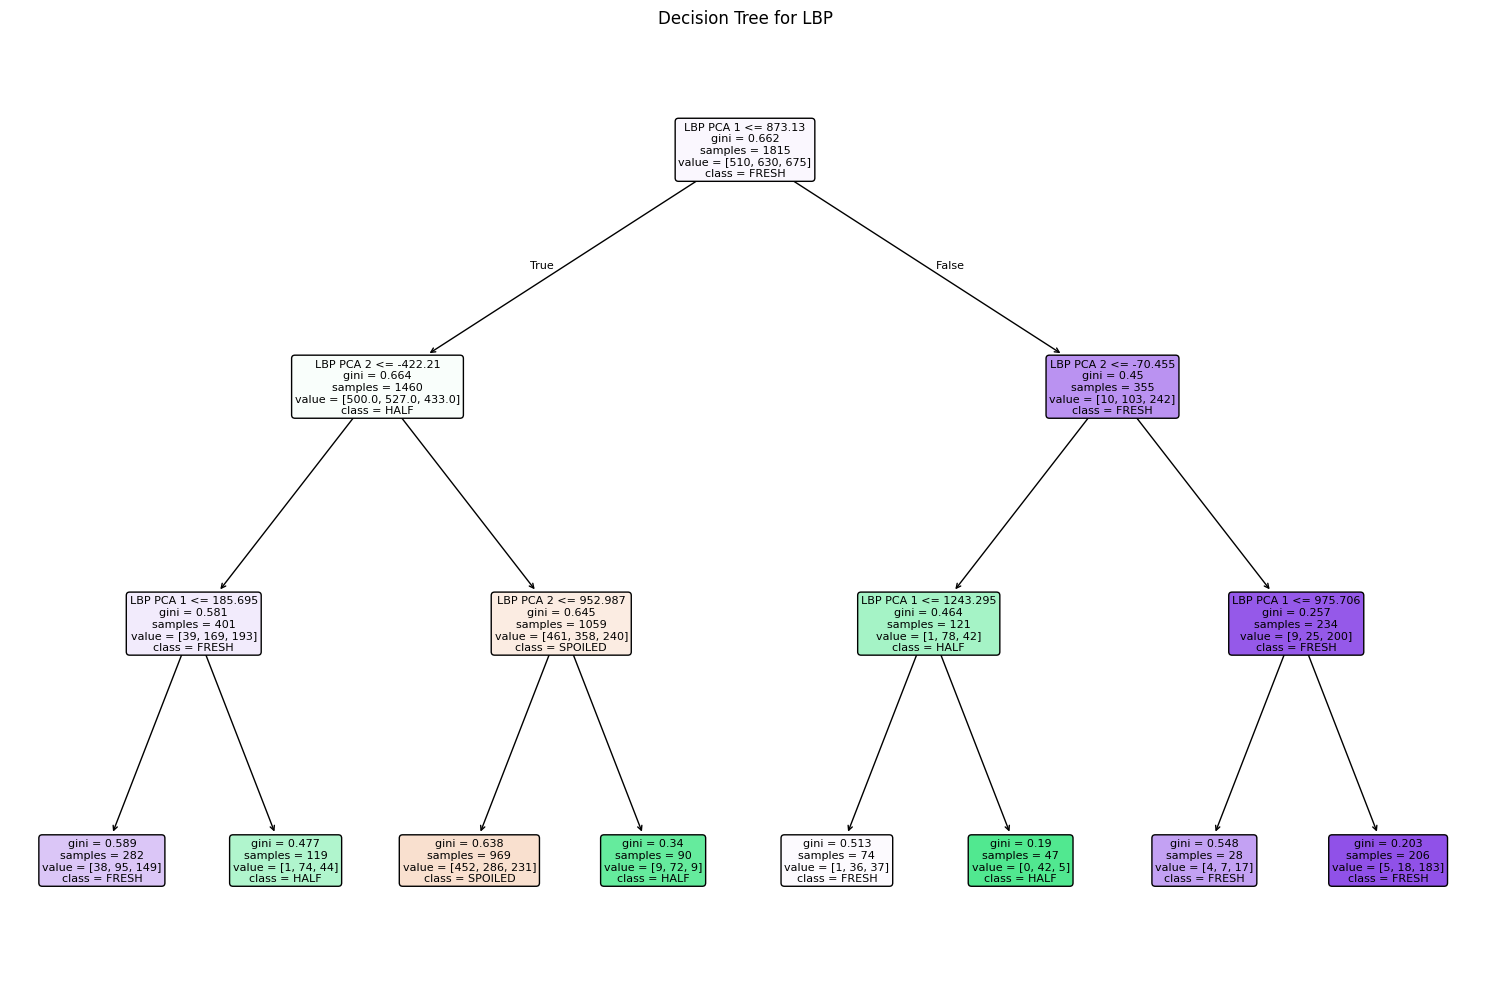


--- Decision Tree Classification for HOG features ---
Decision Tree Accuracy: 0.4501

Classification Report:
              precision    recall  f1-score   support

     SPOILED       0.45      0.53      0.49       114
        HALF       0.41      0.50      0.45       159
       FRESH       0.51      0.35      0.42       178

    accuracy                           0.45       451
   macro avg       0.46      0.46      0.45       451
weighted avg       0.46      0.45      0.45       451



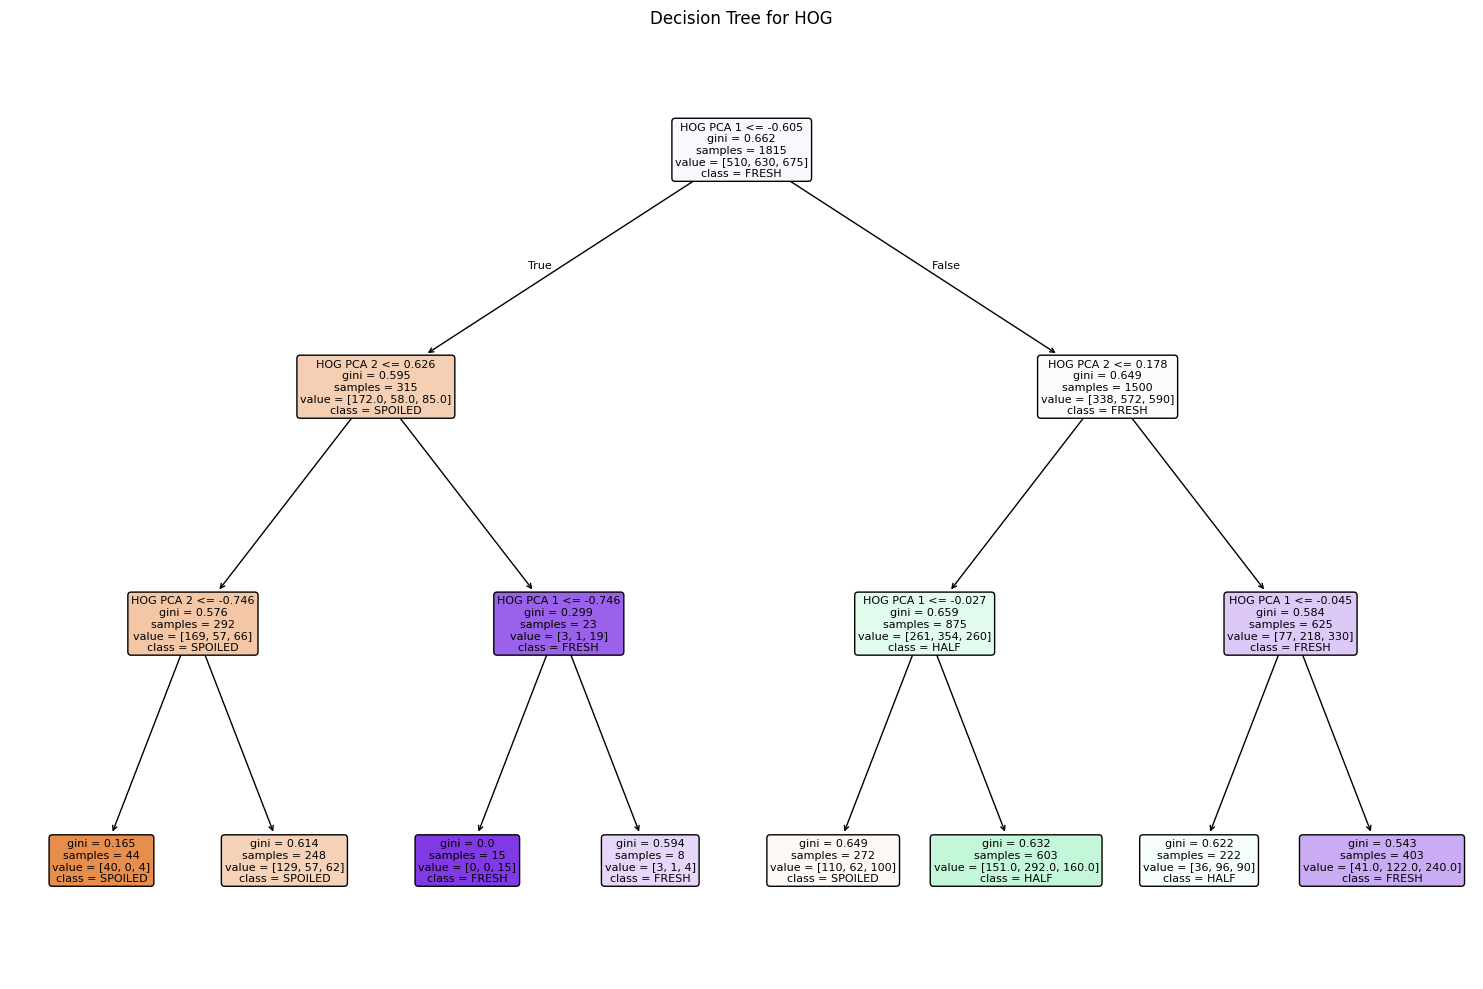


--- Comparison of Decision Tree Results ---
Histogram: Accuracy = 0.6430
LBP: Accuracy = 0.5055
HOG: Accuracy = 0.4501


In [40]:
def run_decision_tree_on_pca_dataframes(train_dfs, test_dfs, train_labels, test_labels, feature_names=None, max_depth=3):
    """
    Run decision tree classification on multiple PCA-transformed dataframes.
    
    Parameters:
    - train_dfs: Dictionary of training dataframes {'name': dataframe}
    - test_dfs: Dictionary of testing dataframes {'name': dataframe}
    - train_labels: Training labels
    - test_labels: Testing labels
    - feature_names: Optional dictionary of feature names for each dataframe
    - max_depth: Maximum depth for decision tree
    
    Returns:
    - results: Dictionary containing trained models and their performance metrics
    """
    results = {}
    
    for name in train_dfs.keys():
        print(f"\n--- Decision Tree Classification for {name} features ---")
        
        # Get the dataframes
        train_df = train_dfs[name]
        test_df = test_dfs[name]
        
        # Determine feature names if not provided
        names = None
        if feature_names and name in feature_names:
            names = feature_names[name]
        else:
            names = train_df.columns.tolist()
        
        # Train decision tree
        model, accuracy, report = train_decision_tree(
            x_train_tree=train_df.values,
            y_train_tree=train_labels,
            x_test_tree=test_df.values,
            y_test_tree=test_labels,
            filter=name,
            max_depth=max_depth,
            show_tree=True,
            feature_names=names
        )
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report
        }
    
    # Compare results
    print("\n--- Comparison of Decision Tree Results ---")
    for name, result in results.items():
        print(f"{name}: Accuracy = {result['accuracy']:.4f}")
    
    return results

# Example usage:
train_dfs = {
    'Histogram': train_df_hist,
    'LBP': train_df_lbp,
    'HOG': train_df_hog
}

test_dfs = {
    'Histogram': test_df_hist,
    'LBP': test_df_lbp,
    'HOG': test_df_hog
}

# Optional: Define feature names for better visualization
feature_names = {
    'Histogram': ['Histogram PCA 1', 'Histogram PCA 2'],
    'LBP': ['LBP PCA 1', 'LBP PCA 2'],
    'HOG': ['HOG PCA 1', 'HOG PCA 2']
}

# Run the analysis
results = run_decision_tree_on_pca_dataframes(
    train_dfs=train_dfs,
    test_dfs=test_dfs,
    train_labels=train_y,
    test_labels=test_y,
    feature_names=feature_names,
    max_depth=3
)